In [5]:
# imports
import os
import sys
import glob
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image


#####################################
### Provided functions start here ###
#####################################

# Image loading and saving

def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)


# Plot the height map

def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])


def display_output(albedo_image, height_map):
    fig = plt.figure()
    plt.imshow(albedo_image, cmap='gray')
    plt.axis('off')
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(20, 20)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)


# Plot the surface normals

def plot_surface_normals(surface_normals):
    """
    surface_normals: h x w x 3 matrix.
    """
    fig = plt.figure()
    ax = plt.subplot(1, 3, 1)
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0])
    ax = plt.subplot(1, 3, 2)
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1])
    ax = plt.subplot(1, 3, 3)
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2])


In [195]:
#######################################
### Your implementation starts here ###
#######################################

def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """
    processed_imarray = np.zeros(imarray.shape)
    for i in range(imarray.shape[2]):
        processed_imarray[:,:,i] = np.maximum(imarray[:,:,i] - ambimage, 0)
        processed_imarray[:,:,i] = processed_imarray[:,:,i] / 255.0
    
    # plt.figure()
    # plt.imshow(imarray[:,:,0])
    # print(imarray[:,:,0])
    # plt.figure()
    # plt.imshow(processed_imarray[:,:,0])
    # print(processed_imarray[:,:,0])

    return processed_imarray


def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    h=imarray.shape[0]
    w=imarray.shape[1]
    pix = h*w
    # I = np.reshape(imarray, (light_dirs.shape[0], pix),order="F")
    I = np.reshape(imarray.transpose(2,0,1), (light_dirs.shape[0], pix))
    # g: 3*pix
    g = np.linalg.lstsq(light_dirs, I, rcond=None)[0]
    albedo_image = np.linalg.norm(g,axis=0)
    surface_normals = g / albedo_image
    surface_normals = np.reshape(surface_normals,(3,h,w))
    surface_normals = np.stack(surface_normals[0:3],axis=2)
    return np.reshape(albedo_image,(h, w)), surface_normals



def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals:h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
    """
    height_map = np.zeros((surface_normals.shape[0:2]))
    fx = surface_normals[:,:,0]/surface_normals[:,:,2]
    fy = surface_normals[:,:,1]/surface_normals[:,:,2]
    if integration_method =='row':
        fx_row = np.cumsum(fx,axis=1)[0].reshape(1,fx.shape[1]) # row first
        fy_row = fy
        fy_row[0,:] = fx_row + fy[0,:]
        height_map = np.cumsum(fy_row, axis=0)

    if integration_method =='column':
        fy_col = np.cumsum(fy,axis=0)[:,0] # row first
        fx_col = fx
        fx_col[:,0] = fy_col + fx[:,0]
        height_map = np.cumsum(fx_col, axis=1)

    if integration_method =='average':
        height_map = (get_surface(surface_normals, 'column')+get_surface(surface_normals, 'row'))/2
    return height_map

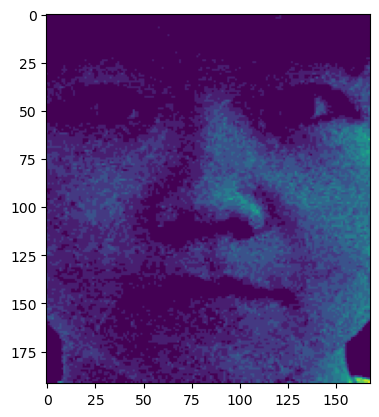

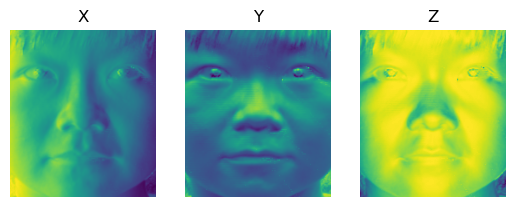

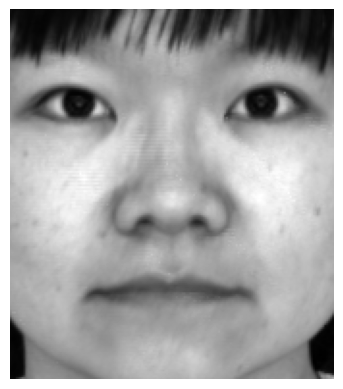

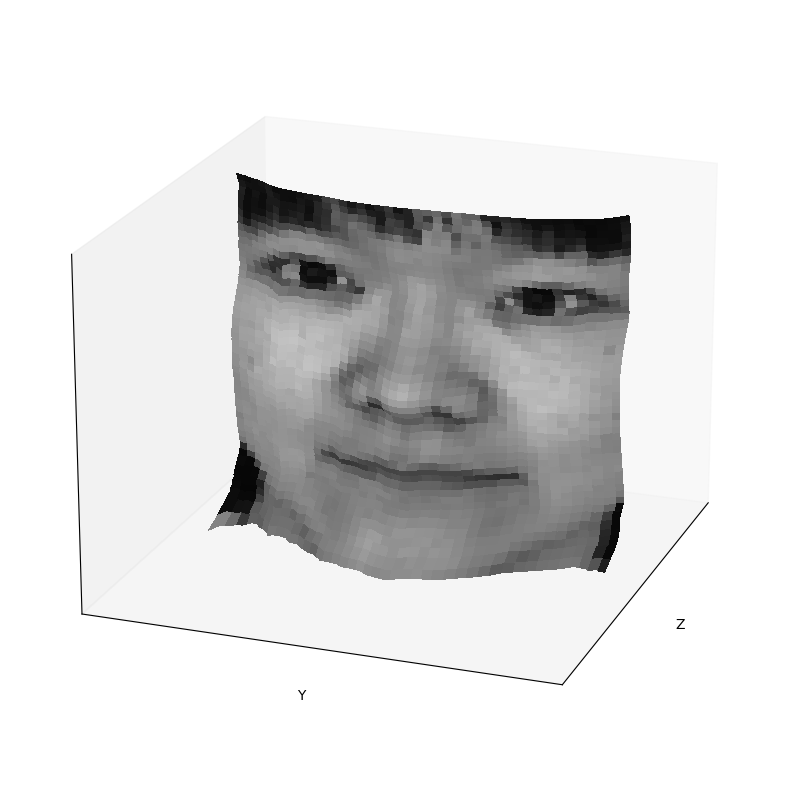

In [196]:
# Main function
if __name__ == '__main__':
    root_path = 'croppedyale/'
    subject_name = 'yaleB05'
    integration_method = 'average'
    save_flag = True

    full_path = '%s%s' % (root_path, subject_name)
    ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                        64)
    plt.imshow(ambient_image)
    processed_imarray = preprocess(ambient_image, imarray)

    albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                    light_dirs)
    plot_surface_normals(surface_normals)
    
    height_map = get_surface(surface_normals, integration_method)

    if save_flag:
        save_outputs(subject_name, albedo_image, surface_normals)


    display_output(albedo_image, height_map)
